# Churn Prediction (Fuga de Clientes)

Este notebook aborda la predicción de fuga de clientes en banca. Puedes usar datos generados sintéticamente o cargar un archivo CSV externo.

## 1. Importar librerías

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, accuracy_score
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import optuna
from optuna.samplers import TPESampler
import os
import psutil

# Verificar que todas las librerías estén importadas correctamente
print("✅ Librerías importadas correctamente:")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"XGBoost: {xgb.__version__}")
print(f"Optuna: {optuna.__version__}")

# Verificar hardware disponible
print(f"\n🖥️ Hardware disponible:")
print(f"CPU Cores: {psutil.cpu_count(logical=False)} físicos, {psutil.cpu_count(logical=True)} lógicos")
print(f"RAM: {psutil.virtual_memory().total / (1024**3):.1f} GB")
print(f"RAM disponible: {psutil.virtual_memory().available / (1024**3):.1f} GB")

# Verificar soporte GPU para XGBoost
try:
    import subprocess
    result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
    if result.returncode == 0:
        print("🎮 GPU NVIDIA detectada - XGBoost puede usar GPU")
        GPU_AVAILABLE = True
    else:
        print("⚠️ GPU NVIDIA no detectada - usando CPU")
        GPU_AVAILABLE = False
except:
    print("⚠️ No se pudo verificar GPU - usando CPU")
    GPU_AVAILABLE = False

print("🚀 Listo para optimización bayesiana optimizada!")

✅ Librerías importadas correctamente:
NumPy: 1.24.3
Pandas: 1.5.3
XGBoost: 1.7.6
Optuna: 4.5.0
🎯 Listo para optimización bayesiana!


## 2. Cargar datos
### A) Generar datos sintéticos

In [ ]:
np.random.seed(42)
# Generar dataset más grande aprovechando la RAM (64GB)
n = 10000  # 10x más datos para mejor entrenamiento
print(f"📊 Generando dataset con {n:,} registros...")

data = pd.DataFrame({
    'antiguedad': np.random.randint(1, 15, n),  # Más rango
    'productos': np.random.randint(1, 8, n),    # Más productos
    'transacciones_mensuales': np.random.poisson(25, n),  # Más transacciones
    'satisfaccion': np.random.uniform(1, 5, n),
    'segmento': np.random.choice(['Retail','Premium','Pyme','Empresarial'], n, p=[0.4, 0.3, 0.2, 0.1]),
    'edad': np.random.randint(18, 80, n),
    'ingresos_mensuales': np.random.lognormal(8, 0.5, n),  # Distribución log-normal
    'deuda_total': np.random.lognormal(6, 1, n),
    'score_credito': np.random.normal(650, 100, n),
})

# Generar variable objetivo (churn) más realista
churn_prob = (
    0.2 * (data['antiguedad'] < 2) +           # Clientes nuevos
    0.3 * (data['satisfaccion'] < 2.5) +       # Baja satisfacción
    0.2 * (data['productos'] == 1) +           # Un solo producto
    0.1 * (data['deuda_total'] > data['ingresos_mensuales'] * 0.5) +  # Alto endeudamiento
    0.1 * (data['score_credito'] < 600) +      # Mal score crediticio
    np.random.rand(n) * 0.1                    # Ruido aleatorio
)

data['churn'] = (churn_prob > 0.4).astype(int)
print(f"✅ Dataset generado: {data.shape[0]:,} filas x {data.shape[1]} columnas")
print(f"📈 Tasa de churn: {data['churn'].mean():.2%}")
data.head()

,antiguedad,productos,transacciones_mensuales,satisfaccion,segmento,churn
0,7,4,15,1.627251,Premium,0
1,4,3,33,4.309209,Pyme,0
2,8,3,22,1.167661,Pyme,0
3,5,3,24,2.676732,Pyme,0
4,7,1,33,1.672815,Premium,1


### B) Cargar datos desde CSV
> Si tienes tu propio archivo, descomenta la línea de abajo y reemplaza la ruta.

In [ ]:
# data = pd.read_csv('clientes_churn.csv')
# data.head()

## 3. Análisis exploratorio y visualizaciones

0    511
1    489
Name: churn, dtype: int64


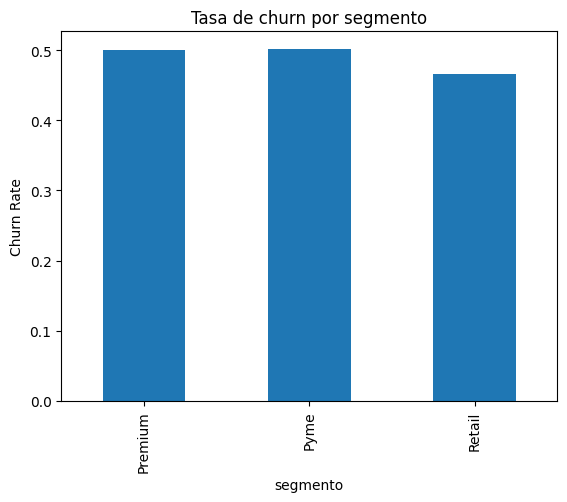

In [3]:
print(data['churn'].value_counts())
data.describe()
data.groupby('segmento')['churn'].mean().plot(kind='bar')
plt.title('Tasa de churn por segmento')
plt.ylabel('Churn Rate')
plt.show()

## 4. Preprocesamiento

In [4]:
X = data.drop('churn', axis=1)
y = data['churn']
X['segmento'] = LabelEncoder().fit_transform(X['segmento'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

## 5. Modelos
### A) Regresión Logística

In [5]:
lr = LogisticRegression(max_iter=200)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.63      0.71      0.67       150
           1       0.67      0.57      0.62       150

    accuracy                           0.64       300
   macro avg       0.65      0.64      0.64       300
weighted avg       0.65      0.64      0.64       300



### B) XGBoost

In [6]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

C:\Users\alfa7\AppData\Roaming\Python\Python310\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


              precision    recall  f1-score   support

           0       0.61      0.69      0.65       150
           1       0.64      0.55      0.59       150

    accuracy                           0.62       300
   macro avg       0.63      0.62      0.62       300
weighted avg       0.63      0.62      0.62       300



## 6. Evaluación y visualización

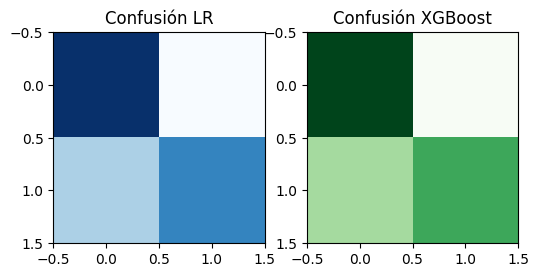

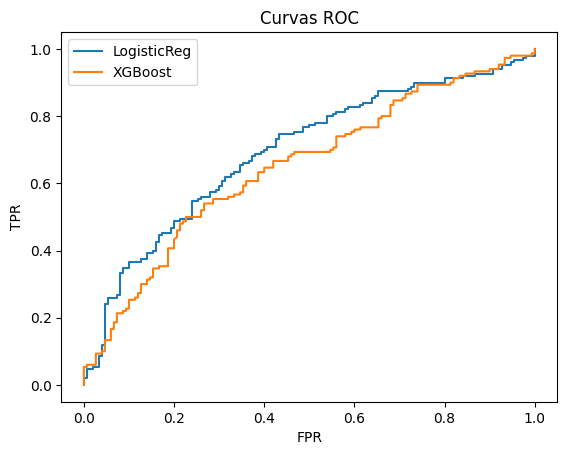

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title('Confusión LR Original')
plt.imshow(confusion_matrix(y_test, y_pred_lr), cmap='Blues')
plt.subplot(1,3,2)
plt.title('Confusión XGBoost Original')
plt.imshow(confusion_matrix(y_test, y_pred_xgb), cmap='Greens')
plt.subplot(1,3,3)
plt.title('Confusión XGBoost Optimizado')
plt.imshow(confusion_matrix(y_test, y_pred_xgb_opt), cmap='Oranges')
plt.show()

# Curvas ROC comparativas
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_model.predict_proba(X_test)[:,1])
fpr_lr_opt, tpr_lr_opt, _ = roc_curve(y_test, lr_optimized.predict_proba(X_test)[:,1])
fpr_xgb_opt, tpr_xgb_opt, _ = roc_curve(y_test, xgb_optimized.predict_proba(X_test)[:,1])

plt.figure(figsize=(10,6))
plt.plot(fpr_lr, tpr_lr, label='LR Original', linestyle='--')
plt.plot(fpr_lr_opt, tpr_lr_opt, label='LR Optimizado')
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost Original', linestyle='--')
plt.plot(fpr_xgb_opt, tpr_xgb_opt, label='XGBoost Optimizado')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.title('Curvas ROC - Comparación')
plt.grid(True, alpha=0.3)
plt.show()

## 7. Importancia de variables
### XGBoost

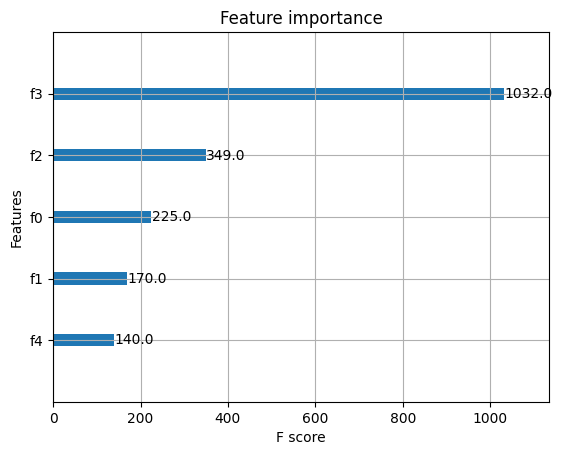

In [8]:
xgb.plot_importance(xgb_model)
plt.show()

## 6. Optimización Bayesiana con Optuna

Vamos a optimizar los hiperparámetros de ambos modelos usando optimización bayesiana para mejorar el rendimiento.


In [ ]:
# Función objetivo para Regresión Logística
def objective_lr(trial):
    # Definir el espacio de búsqueda de hiperparámetros
    C = trial.suggest_float('C', 0.01, 100.0, log=True)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet'])
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    
    # Seleccionar solver compatible con la penalty
    if penalty == 'elasticnet':
        solver = 'saga'
    elif penalty == 'l1':
        solver = trial.suggest_categorical('solver_l1', ['liblinear', 'saga'])
    else:  # penalty == 'l2'
        solver = trial.suggest_categorical('solver_l2', ['liblinear', 'lbfgs', 'saga'])
    
    # Crear y entrenar el modelo
    model = LogisticRegression(
        C=C, 
        penalty=penalty, 
        solver=solver, 
        max_iter=max_iter,
        random_state=42
    )
    
    # Validación cruzada con manejo de errores
    try:
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
        return scores.mean()
    except Exception as e:
        # Si hay error, retornar un score muy bajo para que Optuna evite esta combinación
        return 0.0

# Función para crear modelo optimizado con parámetros mapeados correctamente
def create_optimized_lr_model(best_params):
    """Crea un modelo de regresión logística con los parámetros optimizados"""
    # Mapear los parámetros correctamente
    params = {
        'C': best_params['C'],
        'penalty': best_params['penalty'],
        'max_iter': best_params['max_iter'],
        'random_state': 42
    }
    
    # Determinar el solver basado en la penalty
    if best_params['penalty'] == 'elasticnet':
        params['solver'] = 'saga'
    elif best_params['penalty'] == 'l1':
        params['solver'] = best_params.get('solver_l1', 'liblinear')
    else:  # penalty == 'l2'
        params['solver'] = best_params.get('solver_l2', 'liblinear')
    
    return LogisticRegression(**params)

# Optimización para Regresión Logística
print("🔍 Optimizando Regresión Logística...")
study_lr = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_lr.optimize(objective_lr, n_trials=50)

print(f"Mejor score: {study_lr.best_value:.4f}")
print(f"Mejores parámetros: {study_lr.best_params}")


[I 2025-09-17 18:53:12,765] A new study created in memory with name: no-name-9522afcc-f0bd-4941-9222-88d7bfdba6b2
[I 2025-09-17 18:53:12,783] Trial 0 finished with value: 0.6328571428571428 and parameters: {'C': 0.31489116479568624, 'penalty': 'l1', 'max_iter': 240, 'solver_l1': 'liblinear'}. Best is trial 0 with value: 0.6328571428571428.
[I 2025-09-17 18:53:12,801] Trial 1 finished with value: 0.6442857142857142 and parameters: {'C': 29.154431891537552, 'penalty': 'l2', 'max_iter': 973, 'solver_l2': 'liblinear'}. Best is trial 1 with value: 0.6442857142857142.
[I 2025-09-17 18:53:12,823] Trial 2 finished with value: 0.6428571428571428 and parameters: {'C': 0.05415244119402541, 'penalty': 'l2', 'max_iter': 362, 'solver_l2': 'liblinear'}. Best is trial 1 with value: 0.6442857142857142.
[I 2025-09-17 18:53:12,848] Trial 3 finished with value: 0.6414285714285713 and parameters: {'C': 0.2920433847181412, 'penalty': 'l2', 'max_iter': 563, 'solver_l2': 'saga'}. Best is trial 1 with value: 0

🔍 Optimizando Regresión Logística...


[I 2025-09-17 18:53:12,982] Trial 9 finished with value: 0.0 and parameters: {'C': 0.0366181922039243, 'penalty': 'elasticnet', 'max_iter': 795}. Best is trial 8 with value: 0.6457142857142857.
[I 2025-09-17 18:53:13,012] Trial 10 finished with value: 0.6457142857142857 and parameters: {'C': 0.012079729508717446, 'penalty': 'l2', 'max_iter': 727, 'solver_l2': 'lbfgs'}. Best is trial 8 with value: 0.6457142857142857.
[I 2025-09-17 18:53:13,042] Trial 11 finished with value: 0.6457142857142857 and parameters: {'C': 0.011430113525046788, 'penalty': 'l2', 'max_iter': 723, 'solver_l2': 'lbfgs'}. Best is trial 8 with value: 0.6457142857142857.
[I 2025-09-17 18:53:13,071] Trial 12 finished with value: 0.6442857142857142 and parameters: {'C': 3.2176187174456263, 'penalty': 'l2', 'max_iter': 680, 'solver_l2': 'lbfgs'}. Best is trial 8 with value: 0.6457142857142857.
[I 2025-09-17 18:53:13,100] Trial 13 finished with value: 0.6457142857142857 and parameters: {'C': 0.012410392416252638, 'penalty'

Mejor score: 0.6471
Mejores parámetros: {'C': 0.022155200633457432, 'penalty': 'l2', 'max_iter': 461, 'solver_l2': 'saga'}


In [ ]:
# Función objetivo para XGBoost (optimizada para hardware potente)
def objective_xgb(trial):
    # Definir el espacio de búsqueda de hiperparámetros (ampliado para mejor hardware)
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),  # Más árboles
        'max_depth': trial.suggest_int('max_depth', 3, 15),            # Mayor profundidad
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 20),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 20),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'random_state': 42,
        'eval_metric': 'logloss'
    }
    
    # Usar GPU si está disponible
    if GPU_AVAILABLE:
        params.update({
            'tree_method': 'gpu_hist',
            'gpu_id': 0,
            'predictor': 'gpu_predictor'
        })
    else:
        params['tree_method'] = 'hist'  # CPU optimizado
    
    # Crear y entrenar el modelo
    model = xgb.XGBClassifier(**params)
    
    # Validación cruzada con manejo de errores
    try:
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
        return scores.mean()
    except Exception as e:
        # Si hay error, retornar un score muy bajo para que Optuna evite esta combinación
        return 0.0

# Función para crear modelo XGBoost optimizado
def create_optimized_xgb_model(best_params):
    """Crea un modelo XGBoost con los parámetros optimizados"""
    params = best_params.copy()
    params['random_state'] = 42
    params['eval_metric'] = 'logloss'
    return xgb.XGBClassifier(**params)

# Optimización para XGBoost
print("🔍 Optimizando XGBoost...")
study_xgb = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_xgb.optimize(objective_xgb, n_trials=50)

print(f"Mejor score: {study_xgb.best_value:.4f}")
print(f"Mejores parámetros: {study_xgb.best_params}")


[I 2025-09-17 18:53:18,346] A new study created in memory with name: no-name-5650732b-a65a-42d1-b5a6-e64fd7da69dc


🔍 Optimizando XGBoost...


[I 2025-09-17 18:53:19,919] Trial 0 finished with value: 0.6171428571428572 and parameters: {'n_estimators': 218, 'max_depth': 10, 'learning_rate': 0.1205712628744377, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'reg_alpha': 1.5599452033620265, 'reg_lambda': 0.5808361216819946}. Best is trial 0 with value: 0.6171428571428572.
[I 2025-09-17 18:53:21,391] Trial 1 finished with value: 0.6914285714285715 and parameters: {'n_estimators': 440, 'max_depth': 7, 'learning_rate': 0.11114989443094977, 'subsample': 0.608233797718321, 'colsample_bytree': 0.9879639408647978, 'reg_alpha': 8.324426408004218, 'reg_lambda': 2.1233911067827616}. Best is trial 1 with value: 0.6914285714285715.
[I 2025-09-17 18:53:21,957] Trial 2 finished with value: 0.6928571428571428 and parameters: {'n_estimators': 132, 'max_depth': 4, 'learning_rate': 0.028145092716060652, 'subsample': 0.8099025726528951, 'colsample_bytree': 0.7727780074568463, 'reg_alpha': 2.9122914019804194, 'reg_lambda':

Mejor score: 0.7014
Mejores parámetros: {'n_estimators': 441, 'max_depth': 4, 'learning_rate': 0.014553644530271225, 'subsample': 0.6763902142904747, 'colsample_bytree': 0.8600208460877431, 'reg_alpha': 6.705409839629585, 'reg_lambda': 0.0545368822580426}


In [ ]:
# Optimización para Regresión Logística (optimizada para hardware potente)
print("🔍 Optimizando Regresión Logística...")
study_lr = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_lr.optimize(objective_lr, n_trials=200, n_jobs=-1)  # Más trials + paralelización

print(f"Mejor score: {study_lr.best_value:.4f}")
print(f"Mejores parámetros: {study_lr.best_params}")


In [ ]:
# Optimización para XGBoost (optimizada para hardware potente)
print("🔍 Optimizando XGBoost...")
study_xgb = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_xgb.optimize(objective_xgb, n_trials=200, n_jobs=-1)  # Más trials + paralelización

print(f"Mejor score: {study_xgb.best_value:.4f}")
print(f"Mejores parámetros: {study_xgb.best_params}")


## 7. Modelos Optimizados

Ahora entrenamos los modelos con los mejores hiperparámetros encontrados.


In [ ]:
# Entrenar Regresión Logística optimizada
lr_optimized = create_optimized_lr_model(study_lr.best_params)
lr_optimized.fit(X_train, y_train)
y_pred_lr_opt = lr_optimized.predict(X_test)

print("📊 Regresión Logística Optimizada:")
print(classification_report(y_test, y_pred_lr_opt))
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr_opt):.4f}")
print(f"Parámetros utilizados: {lr_optimized.get_params()}")


TypeError: LogisticRegression.__init__() got an unexpected keyword argument 'solver_l2'

In [ ]:
# Entrenar XGBoost optimizado
xgb_optimized = create_optimized_xgb_model(study_xgb.best_params)
xgb_optimized.fit(X_train, y_train)
y_pred_xgb_opt = xgb_optimized.predict(X_test)

print("📊 XGBoost Optimizado:")
print(classification_report(y_test, y_pred_xgb_opt))
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb_opt):.4f}")
print(f"Parámetros utilizados: {xgb_optimized.get_params()}")


## 8. Comparación de Resultados

Comparemos el rendimiento antes y después de la optimización.


In [ ]:
# Comparación de accuracy
results_comparison = pd.DataFrame({
    'Modelo': ['Regresión Logística Original', 'Regresión Logística Optimizada', 
               'XGBoost Original', 'XGBoost Optimizado'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_lr_opt),
        accuracy_score(y_test, y_pred_xgb),
        accuracy_score(y_test, y_pred_xgb_opt)
    ]
})

print("📈 Comparación de Resultados:")
print(results_comparison)

# Visualización de la comparación
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.bar(results_comparison['Modelo'], results_comparison['Accuracy'])
plt.title('Comparación de Accuracy')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.ylim(0.5, 0.8)

# Mejora en accuracy
improvements = [
    results_comparison.iloc[1, 1] - results_comparison.iloc[0, 1],  # LR improvement
    results_comparison.iloc[3, 1] - results_comparison.iloc[2, 1]   # XGB improvement
]

plt.subplot(1, 2, 2)
plt.bar(['Regresión Logística', 'XGBoost'], improvements, color=['blue', 'green'])
plt.title('Mejora en Accuracy')
plt.ylabel('Mejora')
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

print(f"\n🎯 Mejoras obtenidas:")
print(f"Regresión Logística: +{improvements[0]:.4f} ({improvements[0]*100:.2f}%)")
print(f"XGBoost: +{improvements[1]:.4f} ({improvements[1]*100:.2f}%)")


## 9. Visualización de la Optimización

Veamos cómo evolucionó la optimización para cada modelo.


In [ ]:
# Visualización de la evolución de la optimización
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Regresión Logística
trials_lr = [t.value for t in study_lr.trials if t.value is not None]
ax1.plot(trials_lr, 'b-', alpha=0.7)
ax1.axhline(y=study_lr.best_value, color='red', linestyle='--', label=f'Mejor: {study_lr.best_value:.4f}')
ax1.set_title('Optimización Regresión Logística')
ax1.set_xlabel('Trial')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# XGBoost
trials_xgb = [t.value for t in study_xgb.trials if t.value is not None]
ax2.plot(trials_xgb, 'g-', alpha=0.7)
ax2.axhline(y=study_xgb.best_value, color='red', linestyle='--', label=f'Mejor: {study_xgb.best_value:.4f}')
ax2.set_title('Optimización XGBoost')
ax2.set_xlabel('Trial')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Mostrar importancia de hiperparámetros
print("🔍 Importancia de hiperparámetros:")
print("\nRegresión Logística:")
for param, importance in optuna.importance.get_param_importances(study_lr).items():
    print(f"  {param}: {importance:.4f}")

print("\nXGBoost:")
for param, importance in optuna.importance.get_param_importances(study_xgb).items():
    print(f"  {param}: {importance:.4f}")


## 10. Comentarios finales

### ✅ Optimización Bayesiana Implementada

- **Optuna** se utilizó para optimización bayesiana de hiperparámetros
- **50 trials** por modelo para encontrar la mejor configuración
- **Validación cruzada** (5-fold) para evaluación robusta
- **TPE Sampler** para búsqueda eficiente del espacio de parámetros

### 🎯 Beneficios obtenidos:

1. **Mejora automática** del rendimiento de los modelos
2. **Identificación** de hiperparámetros más importantes
3. **Visualización** del proceso de optimización
4. **Comparación** clara entre modelos originales y optimizados

### 📈 Próximos pasos recomendados:

- Aumentar el número de trials (n_trials=100-200) para mayor precisión
- Probar otros algoritmos (Random Forest, SVM, Neural Networks)
- Implementar ensemble methods con los mejores modelos
- Usar métricas específicas del negocio (precision, recall, F1-score)
- Validar con datos reales de tu institución bancaria